In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
import albumentations

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from torchmetrics import F1
from pytorch_toolbelt import losses as L
import timm

In [2]:
root_path = '/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/datasets/'
print(os.listdir(root_path))

['Eucalyptus sp.', 'Brassica', 'Taraxacum', 'Rosmarinus officinalis', 'Tilia', 'Erica.m', 'Lavandula', 'Cistus sp', 'Pinus', 'Cardus', 'Citrus sp', 'Helianthus annuus']


In [3]:
list_folders=os.listdir(root_path)

In [4]:
list_files = []
for (dirpath, dirnames, filenames) in os.walk(root_path):
        list_files += [os.path.join(dirpath, file) for file in filenames]
print(f'Total amount of files: {len(list_files)}')

Total amount of files: 8970


In [5]:
df = pd.DataFrame()
for folder in list_folders:
    df_f1 = pd.DataFrame({folder: os.listdir(root_path+folder) })
    df = pd.concat([df, df_f1], ignore_index=False, axis=1 )
df.head()

,Eucalyptus sp.,Brassica,Taraxacum,Rosmarinus officinalis,Tilia,Erica.m,Lavandula,Cistus sp,Pinus,Cardus,Citrus sp,Helianthus annuus
0,Eucalyptus sp.-0-Sample_3_Capture_128.bmp,Brassica-0-Sample_61_Olea_Brassica_Salix_0_28....,Taraxacum-0-Sample_72_Arbutus_Erica_0911211048...,Rosmarinus officinalis-0-Sample_19_Rosmarinus_...,Tilia-0-Sample_49_Tilia_Flor_3105211737_22.588...,Erica.m-4-Sample_72_Arbutus_Erica_0311211548_0...,Lavandula-4-Sample_71_Lavanda_Espliego_1810211...,Cistus sp-4-Sample_62_Thymus_0_19.666667_0.000...,Pinus-1-Sample_77_Pinus_Poaceae_2112211334_0_-...,Cardus-0-Sample_61_Olea_Brassica_Salix_0_22.73...,Citrus sp-0-Sample_67_Citrus_2909211453_0_9.00...,Helianthus annuus-1-Sample_17_sunflower_070921...
1,Eucalyptus sp.-0-Sample_66_Echium_Lotus_Castan...,Brassica-0-Sample_21_Rapseed_1105211748_3.5294...,Taraxacum-0-Sample_46_Taraxacum_3003211226_15....,Rosmarinus officinalis-0-Sample_19_Rosmarinus_...,Tilia-0-Sample_47_Tilia_0706211343_0_21.205_2....,Vaccinium_m-0-Sample_64_Erica.t_Calluna_010921...,Lavandula-0-Sample_70_Cantueso_2010210942_0_30...,Cistus sp-1-Sample_61_Olea_Brassica_Salix_0_26...,Pinus-1-Sample_77_Pinus_Poaceae_2112211254_0_3...,Cardus-1-Sample_67_Citrus_2909211030_0_41.276_...,Citrus sp-0-Citrus_no_fucsin_34.632_-0.556_0.8...,Helianthus annuus-1-Sample_17_sunflower_0_19.5...
2,Eucalyptus sp.-1-Sample_23_Euc_Ech_Coro_8.679_...,Brassica-1-Sample_21_Rapseed_27.596_9.269_0.78...,Taraxacum-1-Sample_67_Citrus_0410211143_0_18.6...,Rosmarinus officinalis-0-Sample_19_Rosmarinus_...,Tilia-0-Sample_47_Tilia_0206211356_0_18.583_-1...,Vaccinium_m-3-Sample_63_Rosmarinus_Prunus_0_23...,Lavandula-0-Sample_70_Cantueso_1410211700_0_5....,Cistus sp-1-Sample_72_Arbutus_Erica_2311211327...,Pinus-2-Sample_77_Pinus_Poaceae_2112211301_0_1...,Cardus-0-Sample_68_Persea_0410210944_0_43.1085...,Citrus sp-1-Sample_67_Citrus_2809211605_0_14.1...,Helianthus annuus-0-Sample_22_imported_Ana_13....
3,Eucalyptus sp.-3-Sample_3_Capture_168.bmp,Brassica-1-Sample_21_Rapseed_6.537_-2.756_0.71...,Taraxacum-0-Sample_67_Citrus_0410211004_0_23.4...,Rosmarinus officinalis-0-Sample_75_Liliaceae_P...,Tilia-1-Sample_47_Tilia_0706211538_0_13.339_6....,Vaccinium_m-1-Sample_58_Vaccinium_myrtillus_29...,Lavandula-1-Sample_71_Lavanda_Espliego_2110211...,Cistus sp-1-Sample_67_Citrus_0410211017_0_19.4...,Pinus-0-Sample_32_PINUS_2603211549_21.529412_6...,Cardus-0-Sample_68_Persea_0410210943_0_37.5421...,Citrus sp-0-Sample_67_Citrus_0410211045_0_22.2...,Helianthus annuus-1-Sample_22_imported_Ana_050...
4,Eucalyptus sp.-2-Sample_61_Olea_Brassica_Salix...,Brassica-6-Sample_21_Rapseed_1105211320_1.4117...,Taraxacum-0-Sample_67_Citrus_0410211136_0_22.8...,Rosmarinus officinalis-0-Sample_19_Rosmarinus_...,Tilia-3-Sample_53_Tilia_honey_3105211737_22.94...,Vaccinium_m-0-Sample_64_Erica.t_Calluna_020921...,Lavandula-3-Sample_71_Lavanda_Espliego_2110210...,Cistus sp-1-Sample_62_Thymus_0709211156_0_12.3...,Pinus-1-Sample_17_sunflower_0709211301_0_2.192...,Cardus-1-Sample_17_sunflower_0709211348_0_30.2...,Citrus sp-1-Sample_61_Olea_Brassica_Salix_2007...,Helianthus annuus-1-Sample_44_Cardus_0_20.8257...


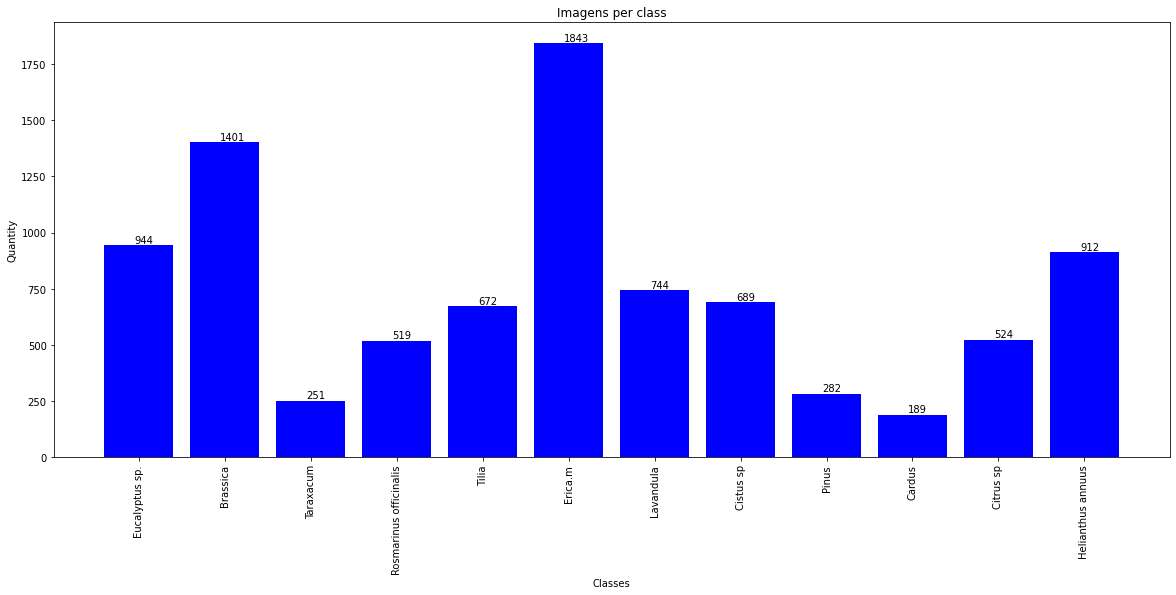

In [6]:
plt.figure(figsize=(20,8))
aa = len(df) - df.isna().sum(axis=0)
plt.bar(aa.index, aa, color='blue')
plt.xlabel('Classes')
plt.xticks(rotation=90)
plt.ylabel('Quantity')
plt.title('Imagens per class')

for index, value in enumerate(aa):
    plt.text(index-0.05, value+10, str(int(value)) )

## Partition of data in train-val-test subsets

In [7]:
list_files = []
labels=[]
for folder in list_folders:
    list_per_folder = os.listdir(os.path.join(root_path, folder))
    for file in list_per_folder:
        list_files += [os.path.join(root_path, folder, file) ]
        labels += [folder]


In [8]:
df = pd.DataFrame({"name":list_files,"labels":labels})
df.head()

,name,labels
0,/mnt/gpid08/datasets/remote_sensing/tmp_from_g...,Eucalyptus sp.
1,/mnt/gpid08/datasets/remote_sensing/tmp_from_g...,Eucalyptus sp.
2,/mnt/gpid08/datasets/remote_sensing/tmp_from_g...,Eucalyptus sp.
3,/mnt/gpid08/datasets/remote_sensing/tmp_from_g...,Eucalyptus sp.
4,/mnt/gpid08/datasets/remote_sensing/tmp_from_g...,Eucalyptus sp.


In [9]:
## Train Test split
x_train, x_test, y_train, y_test = train_test_split(list_files, labels, test_size=0.1, random_state=100, stratify=labels)

## Train val split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.05, random_state=100, stratify=y_train)

df_train = pd.DataFrame({"name":x_train,"labels":y_train})
df_test  = pd.DataFrame({"name":x_test,"labels":y_test})
df_val  = pd.DataFrame({"name":x_val,"labels":y_val})


print(len(df), len(df_train), len(df_test), len(df_val))


8970 7669 897 404


## Faltan histogramas!!

In [10]:
df_val.groupby('labels').count()

,name
labels,
Brassica,63
Cardus,9
Cistus sp,31
Citrus sp,24
Erica.m,83
Eucalyptus sp.,42
Helianthus annuus,41
Lavandula,34
Pinus,13


# Baseline using timm

In [11]:
import timm

In [12]:
# From https://juansensio.com/blog/062_multihead_attention
class Dataset(torch.utils.data.Dataset):
    def __init__(self, mode, df):
        self.mode = mode
        self.df = df #pd.read_csv("/content/drive/MyDrive/melanoma/compartido/isic/isic_2017_train.csv")

        self.mean_img = (0.485, 0.456, 0.406 )
        self.std_img = (0.229, 0.224, 0.225)
        self.classes = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
                        'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']

    def __crop_padding(self,img):
        ## convert to gray
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ## set threshold for 0
        _,thresh = cv2.threshold(img_gray,10,255,cv2.THRESH_BINARY)
        ## find contours
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        x,y,w,h = cv2.boundingRect(cnt)
        crop = img[y:y+h,x:x+w,:]
        return crop

    def __getitem__(self, index):
        name_img = self.df['name'].iloc[index]
        label    = self.df['labels'].iloc[index]
        ## READ IMAGE
        image = plt.imread(name_img)
        image = self.__crop_padding(image)
        target = torch.tensor(self.classes.index(label))
        # print(f'Image shape: {image.shape} \t Target:{target}')
        if self.mode=='train':
            train_augm = albumentations.Compose(
              [
               albumentations.Resize(height=320,width=320),
               albumentations.Normalize(self.mean_img, self.std_img, max_pixel_value=255.0, always_apply=True),
              #  albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
              #  albumentations.Flip(p=0.5)
              ]
            )
            transformed = train_augm(image=image)
            image=transformed['image']
        else:
            valid_augm = albumentations.Compose(
              [
               albumentations.Resize(height=320,width=320),
               albumentations.Normalize(self.mean_img, self.std_img, max_pixel_value=255.0, always_apply=True)
              ]
            )
            transformed = valid_augm(image=image)
            image=transformed['image']

        image = torch.from_numpy(image.transpose()).float()
        target_oh = torch.nn.functional.one_hot(target, num_classes=12).float()
        data = {"image":image,
                "target_oh":target_oh,
                'target':target,
                'class_name':label } 
        # print(f'Image shape: {image.shape} \t Target:{target}')

        return data
    def __len__(self):
        return len(self.df)

class HoneyDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 4, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset
        self.train_ds =  self.Dataset(mode='train',df= df_train)
        self.val_ds   =  self.Dataset(mode='val', df= df_val)
        self.test_ds   =  self.Dataset(mode='test', df= df_test)
    def train_dataloader(self):
        return DataLoader(self.train_ds,
                          batch_size=32,
                          shuffle=True,
                          num_workers=0,
                          pin_memory=True,
                          drop_last=True,
                          # sampler=sampler
                          )
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=8, shuffle=False, num_workers=0, pin_memory=True, drop_last=True )
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False )
    
dm = HoneyDataModule(Dataset=Dataset)

In [13]:
data = next(iter(dm.train_dataloader()))
print(data['image'].shape, data['target_oh'].shape)
print(data['target'])
print(data['class_name'])


torch.Size([32, 3, 320, 320]) torch.Size([32, 12])
tensor([ 2,  2,  0,  6,  3,  2,  1,  9,  6, 10,  6,  6, 11,  3,  1,  3,  6, 10,
         5,  8,  6, 11,  1,  8,  3,  5,  3,  8,  1,  3,  1,  1])
['Cistus sp', 'Cistus sp', 'Pinus', 'Eucalyptus sp.', 'Lavandula', 'Cistus sp', 'Erica.m', 'Cardus', 'Eucalyptus sp.', 'Tilia', 'Eucalyptus sp.', 'Eucalyptus sp.', 'Taraxacum', 'Lavandula', 'Erica.m', 'Lavandula', 'Eucalyptus sp.', 'Tilia', 'Helianthus annuus', 'Brassica', 'Eucalyptus sp.', 'Taraxacum', 'Erica.m', 'Brassica', 'Lavandula', 'Helianthus annuus', 'Lavandula', 'Brassica', 'Erica.m', 'Lavandula', 'Erica.m', 'Erica.m']


## ResNet50

In [14]:
resnet_model = timm.create_model('resnet50',pretrained='True',num_classes=12)


In [15]:
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.optim.lr_scheduler import StepLR, MultiStepLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from pytorch_lightning.callbacks import ModelCheckpoint 
import torch.nn.functional as F


In [16]:
val_epoch_loss, val_epoch_acc = [], []
train_epoch_loss, train_epoch_acc = [], []

class LitModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__( )
        # self.save_hyperparameters()
        self.model = model
        self.f1score = F1(num_classes=12, average='weighted')
        
    def forward(self, x):
        return self.model(x)
    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return torch.argmax(y_hat, axis=1)
    def compute_loss_and_metrics(self, batch):
        x, y = batch['image'], batch['target']
        # print(f'X: {x.shape} \t Y: {y.shape}')
        y_hat = self(x)
        # print(f'Output: {y_hat.shape}')
        loss = F.cross_entropy(y_hat, y)
        # acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        
        # y1 = y.detach().cpu().numpy()
        # # print(y1.shape)
        # y_hat1 = torch.argmax(y_hat, axis=1)
        # y_hat1 = y_hat1.detach().cpu().numpy()
        # # print(y_hat1.shape)
        # f1w = f1_score(y1, y_hat1, average='weighted')
        f1w = self.f1score(torch.argmax(y_hat, axis=1), y)
        
        return loss, f1w
    def training_step(self, batch, batch_idx):
        loss, f1w = self.compute_loss_and_metrics(batch)
        self.log('train_loss', loss)
        self.log('train_F1w', f1w, prog_bar=True)
        #print(f'Training_step: loss> {loss} acc:{acc}')
        return {'loss':loss,'f1w':torch.tensor(f1w)}
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_train_f1w  = torch.stack([x['f1w'] for x in outputs]).mean()
        train_epoch_loss.append(avg_train_loss.item())
        train_epoch_acc.append(avg_train_f1w.item())
        #print(f'Epoch {self.current_epoch} TrainLOSS:{avg_train_loss} TrainACC:{avg_train_acc}  ')
    def validation_step(self, batch, batch_idx):
        loss, f1w = self.compute_loss_and_metrics(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_f1w', f1w, prog_bar=True)
        return {'val_loss': torch.tensor(loss.item()), 'val_f1w': torch.tensor(f1w)}
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val_f1w  = torch.stack([x['val_f1w'] for x in outputs]).mean()
        self.log('EarlyStop_Log', avg_val_loss.detach(), on_epoch=True, sync_dist=True)
        self.log('avg_val_f1w', avg_val_f1w.detach(), on_epoch=True, sync_dist=True)
        val_epoch_loss.append(avg_val_loss.item())
        val_epoch_acc.append(avg_val_f1w.item())
        #print(f'VAL-Epoch {self.current_epoch} LOSS:{avg_val_loss} ACC:{avg_val_acc} ')
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        # lr_scheduler = {'scheduler': MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.5,),'interval': 'epoch','frequency':1}
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                            T_0=10,
                                                                            T_mult=1,
                                                                            eta_min=1e-7,
                                                                            verbose=True,
                                                                            )

        return [optimizer], [lr_scheduler]

In [17]:
baseline_model  = LitModel(model=resnet_model)


In [18]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
checkpoint_callback = ModelCheckpoint(dirpath='/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/', 
                                      filename='Base-{epoch}-{val_loss:.2f}-{avg_val_f1w:.2f}',
                                      monitor='avg_val_f1w',
                                      verbose=True,
                                      save_last=None,
                                      save_top_k=1,
                                      save_weights_only=False,
                                      mode='max',
                                      auto_insert_metric_name=True,
                                      )



early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
                                    min_delta=0.00,\
                                    patience=5,\
                                    verbose=False,\
                                    mode='min')
    

In [20]:
gpu = 1 if torch.cuda.is_available() else 0
print(f'Using {gpu} GPUS')


Using 1 GPUS


In [21]:
## Sanity-check
trainer = pl.Trainer(gpus=gpu,
                     callbacks=[checkpoint_callback, early_stop_callback],
                    #  deterministic=True,
                     enable_progress_bar=True,
                    #  progress_bar_
                    #  limit_train_batches=2,
                    #  limit_val_batches=2,
                     max_epochs=20)

# Then you call the fit method passing the PL-module and PL-Datamodule, to start training.
trainer.fit(baseline_model, dm)



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name    | Type   | Params
-----------------------------------
0 | model   | ResNet | 23.5 M
1 | f1score | F1     | 0     
-----------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.130    Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.
Epoch 0:  83%|████████▎ | 239/289 [01:57<00:24,  2.03it/s, loss=0.154, v_num=1666580, train_F1w=0.901]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 289/289 [02:01<00:00,  2.37it/s, loss=0.154, v_num=1666580, train_F1w=0.901, val_loss=0.145, val_f1w=0.946]

Epoch 0, global step 238: avg_val_f1w reached 0.94600 (best 0.94600), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-epoch=0-val_loss=0.14-avg_val_f1w=0.95.ckpt" as top 1


Epoch 1:  83%|████████▎ | 240/289 [01:55<00:23,  2.08it/s, loss=0.0974, v_num=1666580, train_F1w=1.000, val_loss=0.145, val_f1w=0.946]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 289/289 [01:59<00:00,  2.42it/s, loss=0.0974, v_num=1666580, train_F1w=1.000, val_loss=0.0772, val_f1w=0.974]

Epoch 1, global step 477: avg_val_f1w reached 0.97417 (best 0.97417), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-epoch=1-val_loss=0.08-avg_val_f1w=0.97.ckpt" as top 1


Epoch 2:  83%|████████▎ | 240/289 [01:56<00:23,  2.07it/s, loss=0.0579, v_num=1666580, train_F1w=0.966, val_loss=0.0772, val_f1w=0.974]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 289/289 [02:00<00:00,  2.41it/s, loss=0.0579, v_num=1666580, train_F1w=0.966, val_loss=0.0792, val_f1w=0.978]

Epoch 2, global step 716: avg_val_f1w reached 0.97817 (best 0.97817), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-epoch=2-val_loss=0.08-avg_val_f1w=0.98.ckpt" as top 1


Epoch 3:  83%|████████▎ | 240/289 [01:56<00:23,  2.07it/s, loss=0.0275, v_num=1666580, train_F1w=1.000, val_loss=0.0792, val_f1w=0.978]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 289/289 [01:59<00:00,  2.41it/s, loss=0.0275, v_num=1666580, train_F1w=1.000, val_loss=0.0608, val_f1w=0.978]

Epoch 3, global step 955: avg_val_f1w reached 0.97840 (best 0.97840), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-epoch=3-val_loss=0.06-avg_val_f1w=0.98.ckpt" as top 1


Epoch 4:  83%|████████▎ | 240/289 [01:56<00:23,  2.06it/s, loss=0.0156, v_num=1666580, train_F1w=1.000, val_loss=0.0608, val_f1w=0.978]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 289/289 [02:00<00:00,  2.40it/s, loss=0.0156, v_num=1666580, train_F1w=1.000, val_loss=0.0973, val_f1w=0.973]

Epoch 4, global step 1194: avg_val_f1w was not in top 1


Epoch 5:  83%|████████▎ | 240/289 [01:57<00:23,  2.05it/s, loss=0.00726, v_num=1666580, train_F1w=1.000, val_loss=0.0973, val_f1w=0.973]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 289/289 [02:01<00:00,  2.39it/s, loss=0.00726, v_num=1666580, train_F1w=1.000, val_loss=0.057, val_f1w=0.986]

Epoch 5, global step 1433: avg_val_f1w reached 0.98567 (best 0.98567), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-epoch=5-val_loss=0.06-avg_val_f1w=0.99.ckpt" as top 1


Epoch 6:  83%|████████▎ | 240/289 [01:56<00:23,  2.06it/s, loss=0.00417, v_num=1666580, train_F1w=1.000, val_loss=0.057, val_f1w=0.986]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 289/289 [02:00<00:00,  2.40it/s, loss=0.00417, v_num=1666580, train_F1w=1.000, val_loss=0.0653, val_f1w=0.982]

Epoch 6, global step 1672: avg_val_f1w was not in top 1


Epoch 7:  83%|████████▎ | 240/289 [01:56<00:23,  2.05it/s, loss=0.00321, v_num=1666580, train_F1w=1.000, val_loss=0.0653, val_f1w=0.982]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 289/289 [02:00<00:00,  2.39it/s, loss=0.00321, v_num=1666580, train_F1w=1.000, val_loss=0.0587, val_f1w=0.982]

Epoch 7, global step 1911: avg_val_f1w was not in top 1


Epoch 8:  83%|████████▎ | 240/289 [01:57<00:23,  2.05it/s, loss=0.00131, v_num=1666580, train_F1w=1.000, val_loss=0.0587, val_f1w=0.982]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 289/289 [02:00<00:00,  2.39it/s, loss=0.00131, v_num=1666580, train_F1w=1.000, val_loss=0.0582, val_f1w=0.985]

Epoch 8, global step 2150: avg_val_f1w was not in top 1


Epoch 9:  83%|████████▎ | 240/289 [01:57<00:23,  2.05it/s, loss=0.00173, v_num=1666580, train_F1w=1.000, val_loss=0.0582, val_f1w=0.985]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 289/289 [02:01<00:00,  2.39it/s, loss=0.00173, v_num=1666580, train_F1w=1.000, val_loss=0.0573, val_f1w=0.983]

Epoch 9, global step 2389: avg_val_f1w was not in top 1


Epoch 10:  83%|████████▎ | 240/289 [01:57<00:23,  2.04it/s, loss=0.0952, v_num=1666580, train_F1w=1.000, val_loss=0.0573, val_f1w=0.983]
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 289/289 [02:01<00:00,  2.38it/s, loss=0.0952, v_num=1666580, train_F1w=1.000, val_loss=0.160, val_f1w=0.947]

Epoch 10, global step 2628: avg_val_f1w was not in top 1


Epoch 10: 100%|██████████| 289/289 [02:01<00:00,  2.38it/s, loss=0.0952, v_num=1666580, train_F1w=1.000, val_loss=0.160, val_f1w=0.947]


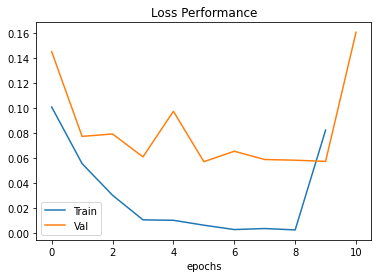

In [55]:
plt.plot(train_epoch_loss[1:])
plt.plot(val_epoch_loss[1:])

plt.legend(['Train', 'Val'])
plt.title('Loss Performance')
plt.xlabel('epochs')
plt.savefig('loss_performace')

In [26]:
model_name = "Base-epoch=5-val_loss=0.06-avg_val_f1w=0.99.ckpt" #"Base-epoch=7-val_loss=0.05-avg_val_f1w=0.99.ckpt"
baseline_model  = LitModel(model=resnet_model)
# /mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-epoch=7-val_loss=0.06-avg_val_f1w=0.98.ckpt

checkpoint =  torch.load('/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/'+ model_name)

baseline_model.load_state_dict(checkpoint['state_dict'])
# baseline_model.load_from_checkpoint("Base-epoch=1-val_loss=0.05-avg_val_f1w=0.98.ckpt")

targets, preds = [],[]
baseline_model.to('cuda')
for ii, data in enumerate(dm.test_dataloader()):
    with torch.no_grad():
        targets.append(data['target'].numpy()) #torch.argmax(data['target'],dim=1).numpy()
        # y = y.reshape((-1,1))
        # print(y.shape)
        ## inference
        o = baseline_model.predict(data['image'].to('cuda')).cpu().numpy()
        # print(o.shape)
        preds.append(o)
        # print(y)
        # print(o)
        # if ii==2:
        #   break
# print(ii)
preds2 = np.vstack([x for x in preds]).reshape(-1,1)
targets2 = np.vstack([x for x in targets]).reshape(-1,1)
target_names = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
          'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']

print(classification_report(targets2, preds2, target_names=target_names))


                        precision    recall  f1-score   support

                 Pinus       0.00      0.00      0.00        28
               Erica.m       0.26      1.00      0.41       184
             Cistus sp       0.00      0.00      0.00        69
             Lavandula       0.00      0.00      0.00        74
             Citrus sp       0.00      0.00      0.00        53
     Helianthus annuus       0.00      0.00      0.00        91
        Eucalyptus sp.       0.00      0.00      0.00        95
Rosmarinus officinalis       0.00      0.00      0.00        52
              Brassica       0.43      0.57      0.49       140
                Cardus       0.00      0.00      0.00        19
                 Tilia       0.00      0.00      0.00        67
             Taraxacum       0.00      0.00      0.00        25

              accuracy                           0.29       897
             macro avg       0.06      0.13      0.08       897
          weighted avg       0.12     

## Adding Weights to the cross Entropy loss

In [28]:
count_train = df_train.groupby('labels').agg({'count'})
count_train['weights'] = 1.02/count_train
count_train['weights_norm'] = count_train['weights']/count_train['weights'].sum()
# count_train['weights_nor'].sum()
count_train

,name,weights,weights_norm
,count,,
labels,,,
Brassica,1198,0.000851,0.029288
Cardus,161,0.006335,0.217930
Cistus sp,589,0.001732,0.059570
Citrus sp,447,0.002282,0.078494
Erica.m,1576,0.000647,0.022263
Eucalyptus sp.,807,0.001264,0.043478
Helianthus annuus,780,0.001308,0.044983
Lavandula,636,0.001604,0.055168


In [29]:
# self.classes = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
#                 'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']
class_weights=torch.Tensor([count_train.loc['Pinus','weights_norm'].item(),
                      count_train.loc['Erica.m','weights_norm'].item(),
                      count_train.loc['Cistus sp','weights_norm'].item(),
                      count_train.loc['Lavandula','weights_norm'].item(),
                      count_train.loc['Citrus sp','weights_norm'].item(),
                      count_train.loc['Helianthus annuus','weights_norm'].item(),
                      count_train.loc['Eucalyptus sp.','weights_norm'].item(),
                      count_train.loc['Rosmarinus officinalis','weights_norm'].item(),
                      count_train.loc['Brassica','weights_norm'].item(),
                      count_train.loc['Cardus','weights_norm'].item(),
                      count_train.loc['Tilia','weights_norm'].item(),
                      count_train.loc['Taraxacum','weights_norm'].item(),
                      ])
class_weights

tensor([0.1456, 0.0223, 0.0596, 0.0552, 0.0785, 0.0450, 0.0435, 0.0790, 0.0293,
        0.2179, 0.0610, 0.1632])

In [30]:
val_epoch_loss_CE, val_epoch_acc_CE = [], []
train_epoch_loss_CE, train_epoch_acc_CE = [], []

class LitModel_CEW(pl.LightningModule):
    def __init__(self, model, class_weights):
        super().__init__( )
        # self.save_hyperparameters()
        self.model = model
        self.class_weights=class_weights.to('cuda')
        # self.class_weights
        
    def forward(self, x):
        return self.model(x)
    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return torch.argmax(y_hat, axis=1)
    def compute_loss_and_metrics(self, batch):
        x, y = batch['image'], batch['target']
        # print(f'X: {x.shape} \t Y: {y.shape}')
        y_hat = self(x)
        # print(f'Output: {y_hat.shape}')
        loss = F.cross_entropy(y_hat, y, weight=self.class_weights)
        # acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        y1 = y.detach().cpu().numpy()
        # print(y1.shape)
        y_hat1 = torch.argmax(y_hat, axis=1)
        y_hat1 = y_hat1.detach().cpu().numpy()
        # print(y_hat1.shape)
        f1w = f1_score(y1, y_hat1, average='weighted')
        return loss, f1w
    def training_step(self, batch, batch_idx):
        loss, f1w = self.compute_loss_and_metrics(batch)
        self.log('train_loss', loss)
        self.log('train_F1w', f1w, prog_bar=True)
        #print(f'Training_step: loss> {loss} acc:{acc}')
        return {'loss':loss,'f1w':torch.tensor(f1w)}
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_train_f1w  = torch.stack([x['f1w'] for x in outputs]).mean()
        train_epoch_loss_CE.append(avg_train_loss.item())
        train_epoch_acc_CE.append(avg_train_f1w.item())
        #print(f'Epoch {self.current_epoch} TrainLOSS:{avg_train_loss} TrainACC:{avg_train_acc}  ')
    def validation_step(self, batch, batch_idx):
        loss, f1w = self.compute_loss_and_metrics(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_f1w', f1w, prog_bar=True)
        return {'val_loss': torch.tensor(loss.item()), 'val_f1w': torch.tensor(f1w)}
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val_f1w  = torch.stack([x['val_f1w'] for x in outputs]).mean()
        self.log('EarlyStop_Log', avg_val_loss.detach(), on_epoch=True, sync_dist=True)
        self.log('avg_val_f1w', avg_val_f1w.detach(), on_epoch=True, sync_dist=True)
        val_epoch_loss_CE.append(avg_val_loss.item())
        val_epoch_acc_CE.append(avg_val_f1w.item())
        #print(f'VAL-Epoch {self.current_epoch} LOSS:{avg_val_loss} ACC:{avg_val_acc} ')
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                    T_0=10,
                                                                    T_mult=1,
                                                                    eta_min=1e-7,
                                                                    verbose=True,
                                                                    )

        # lr_scheduler = {'scheduler': MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.5,),'interval': 'epoch','frequency':1}
        return [optimizer], [lr_scheduler]

In [31]:
baseline_model_CEW  = LitModel_CEW(model=resnet_model, class_weights=class_weights)


In [32]:
checkpoint_callback = ModelCheckpoint(dirpath='/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/', 
                                      filename='Base-CEW-{epoch}-{val_loss:.2f}-{avg_val_f1w:.2f}',
                                      monitor='avg_val_f1w',
                                      verbose=True,
                                      save_last=None,
                                      save_top_k=1,
                                      save_weights_only=False,
                                      mode='max',
                                      auto_insert_metric_name=True,
                                      )



early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
                                    min_delta=0.00,\
                                    patience=5,\
                                    verbose=False,\
                                    mode='min')
    

In [33]:
## Sanity-check
trainer = pl.Trainer(gpus=gpu,
                     callbacks=[checkpoint_callback, early_stop_callback],
                    #  deterministic=True,
                     enable_progress_bar=True,
                    #  progress_bar_
                    #  limit_train_batches=2,
                    #  limit_val_batches=2,
                     max_epochs=20)

# Then you call the fit method passing the PL-module and PL-Datamodule, to start training.
trainer.fit(baseline_model_CEW, dm)



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.130    Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.
Epoch 0:  83%|████████▎ | 239/289 [01:54<00:23,  2.09it/s, loss=0.0427, v_num=1666580, train_F1w=1.000]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 289/289 [01:58<00:00,  2.45it/s, loss=0.0427, v_num=1666580, train_F1w=1.000, val_loss=0.0683, val_f1w=0.983]

Epoch 0, global step 238: avg_val_f1w reached 0.98317 (best 0.98317), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-CEW-epoch=0-val_loss=0.07-avg_val_f1w=0.98.ckpt" as top 1


Epoch 1:  83%|████████▎ | 240/289 [01:52<00:23,  2.13it/s, loss=0.0193, v_num=1666580, train_F1w=1.000, val_loss=0.0683, val_f1w=0.983]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 289/289 [01:56<00:00,  2.48it/s, loss=0.0193, v_num=1666580, train_F1w=1.000, val_loss=0.103, val_f1w=0.968]

Epoch 1, global step 477: avg_val_f1w was not in top 1


Epoch 2:  83%|████████▎ | 240/289 [01:53<00:23,  2.12it/s, loss=0.0154, v_num=1666580, train_F1w=0.973, val_loss=0.103, val_f1w=0.968]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 289/289 [01:57<00:00,  2.47it/s, loss=0.0154, v_num=1666580, train_F1w=0.973, val_loss=0.0836, val_f1w=0.971]

Epoch 2, global step 716: avg_val_f1w was not in top 1


Epoch 3:  83%|████████▎ | 240/289 [01:53<00:23,  2.12it/s, loss=0.00635, v_num=1666580, train_F1w=1.000, val_loss=0.0836, val_f1w=0.971]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 289/289 [01:57<00:00,  2.47it/s, loss=0.00635, v_num=1666580, train_F1w=1.000, val_loss=0.0691, val_f1w=0.982]

Epoch 3, global step 955: avg_val_f1w was not in top 1


Epoch 4:  83%|████████▎ | 240/289 [01:52<00:23,  2.13it/s, loss=0.00315, v_num=1666580, train_F1w=1.000, val_loss=0.0691, val_f1w=0.982]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 289/289 [01:56<00:00,  2.48it/s, loss=0.00315, v_num=1666580, train_F1w=1.000, val_loss=0.074, val_f1w=0.984]

Epoch 4, global step 1194: avg_val_f1w reached 0.98400 (best 0.98400), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-CEW-epoch=4-val_loss=0.07-avg_val_f1w=0.98.ckpt" as top 1


Epoch 5:  83%|████████▎ | 240/289 [01:52<00:23,  2.13it/s, loss=0.00124, v_num=1666580, train_F1w=1.000, val_loss=0.074, val_f1w=0.984]
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 289/289 [01:56<00:00,  2.48it/s, loss=0.00124, v_num=1666580, train_F1w=1.000, val_loss=0.0516, val_f1w=0.982]

Epoch 5, global step 1433: avg_val_f1w was not in top 1


Epoch 6:  83%|████████▎ | 240/289 [01:52<00:23,  2.13it/s, loss=0.00291, v_num=1666580, train_F1w=1.000, val_loss=0.0516, val_f1w=0.982]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 289/289 [01:56<00:00,  2.48it/s, loss=0.00291, v_num=1666580, train_F1w=1.000, val_loss=0.0603, val_f1w=0.980]

Epoch 6, global step 1672: avg_val_f1w was not in top 1


Epoch 7:  83%|████████▎ | 240/289 [01:52<00:23,  2.13it/s, loss=0.00131, v_num=1666580, train_F1w=1.000, val_loss=0.0603, val_f1w=0.980]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 289/289 [01:56<00:00,  2.48it/s, loss=0.00131, v_num=1666580, train_F1w=1.000, val_loss=0.0692, val_f1w=0.982]

Epoch 7, global step 1911: avg_val_f1w was not in top 1


Epoch 8:  83%|████████▎ | 240/289 [01:52<00:22,  2.13it/s, loss=0.00311, v_num=1666580, train_F1w=1.000, val_loss=0.0692, val_f1w=0.982]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 289/289 [01:56<00:00,  2.48it/s, loss=0.00311, v_num=1666580, train_F1w=1.000, val_loss=0.0778, val_f1w=0.980]

Epoch 8, global step 2150: avg_val_f1w was not in top 1


Epoch 9:  83%|████████▎ | 240/289 [01:52<00:22,  2.13it/s, loss=0.000246, v_num=1666580, train_F1w=1.000, val_loss=0.0778, val_f1w=0.980]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 289/289 [01:56<00:00,  2.48it/s, loss=0.000246, v_num=1666580, train_F1w=1.000, val_loss=0.0672, val_f1w=0.978]

Epoch 9, global step 2389: avg_val_f1w was not in top 1


Epoch 10:  83%|████████▎ | 240/289 [01:52<00:23,  2.13it/s, loss=0.168, v_num=1666580, train_F1w=0.970, val_loss=0.0672, val_f1w=0.978]
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 289/289 [01:56<00:00,  2.48it/s, loss=0.168, v_num=1666580, train_F1w=0.970, val_loss=0.173, val_f1w=0.947]

Epoch 10, global step 2628: avg_val_f1w was not in top 1


Epoch 10: 100%|██████████| 289/289 [01:56<00:00,  2.48it/s, loss=0.168, v_num=1666580, train_F1w=0.970, val_loss=0.173, val_f1w=0.947]


In [34]:
model_name = "Base-CEW-epoch=4-val_loss=0.07-avg_val_f1w=0.98.ckpt"

baseline_model  = LitModel_CEW(model=resnet_model, class_weights=class_weights)

# /mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-epoch=7-val_loss=0.06-avg_val_f1w=0.98.ckpt
# baseline_model.model.load_from_checkpoint('/content/drive/MyDrive/dataset_honey/results/'+ model_name)

checkpoint =  torch.load('/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/'+ model_name)

baseline_model.load_state_dict(checkpoint['state_dict'])
# baseline_model.load_from_checkpoint("Base-epoch=1-val_loss=0.05-avg_val_f1w=0.98.ckpt")

targets, preds = [],[]
baseline_model.to('cuda')
for ii, data in enumerate(dm.test_dataloader()):
    with torch.no_grad():
        targets.append(data['target'].numpy()) #torch.argmax(data['target'],dim=1).numpy()
        # y = y.reshape((-1,1))
        # print(y.shape)
        ## inference
        o = baseline_model.predict(data['image'].to('cuda')).cpu().numpy()
        # print(o.shape)
        preds.append(o)
        # print(y)
        # print(o)
        # if ii==2:
        #   break
print(ii)
preds2 = np.vstack([x for x in preds]).reshape(-1,1)
targets2 = np.vstack([x for x in targets]).reshape(-1,1)
target_names = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
          'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']

print(classification_report(targets2, preds2, target_names=target_names))


896
                        precision    recall  f1-score   support

                 Pinus       0.00      0.00      0.00        28
               Erica.m       0.63      0.98      0.77       184
             Cistus sp       0.00      0.00      0.00        69
             Lavandula       0.00      0.00      0.00        74
             Citrus sp       0.00      0.00      0.00        53
     Helianthus annuus       0.00      0.00      0.00        91
        Eucalyptus sp.       0.00      0.00      0.00        95
Rosmarinus officinalis       0.00      0.00      0.00        52
              Brassica       0.22      0.96      0.36       140
                Cardus       0.00      0.00      0.00        19
                 Tilia       0.00      0.00      0.00        67
             Taraxacum       0.00      0.00      0.00        25

              accuracy                           0.35       897
             macro avg       0.07      0.16      0.09       897
          weighted avg       0.16 

## Weighted Sampler

In [35]:
from torch.utils.data import WeightedRandomSampler


In [36]:
count_train.loc['Pinus','weights_norm'].item()

0.1455880557525017

In [37]:
df_train.head()

,name,labels
0,/mnt/gpid08/datasets/remote_sensing/tmp_from_g...,Helianthus annuus
1,/mnt/gpid08/datasets/remote_sensing/tmp_from_g...,Brassica
2,/mnt/gpid08/datasets/remote_sensing/tmp_from_g...,Erica.m
3,/mnt/gpid08/datasets/remote_sensing/tmp_from_g...,Pinus
4,/mnt/gpid08/datasets/remote_sensing/tmp_from_g...,Erica.m


In [38]:


samples_weight = np.array([count_train.loc[t,'weights_norm'].item() for t in df_train['labels']])
samples_weight=torch.from_numpy(samples_weight)

print(samples_weight.shape)

sampler = WeightedRandomSampler(samples_weight, len(samples_weight))


torch.Size([7669])


In [39]:
# From https://juansensio.com/blog/062_multihead_attention
class Dataset(torch.utils.data.Dataset):
    def __init__(self, mode, df):
        self.mode = mode
        self.df = df 
        self.mean_img = (0.485, 0.456, 0.406 )
        self.std_img = (0.229, 0.224, 0.225)
        self.classes = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
                        'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']
    def __crop_padding(self,img):
        ## convert to gray
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ## set threshold for 0
        _,thresh = cv2.threshold(img_gray,10,255,cv2.THRESH_BINARY)
        ## find contours
        contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        cnt = contours[0]
        x,y,w,h = cv2.boundingRect(cnt)
        crop = img[y:y+h,x:x+w,:]
        return crop
    def __getitem__(self, index):
        name_img = self.df['name'].iloc[index]
        label    = self.df['labels'].iloc[index]
        ## READ IMAGE
        image = plt.imread(name_img)
        image = self.__crop_padding(image)
        target = torch.tensor(self.classes.index(label))
        # print(f'Image shape: {image.shape} \t Target:{target}')
        if self.mode=='train':
            train_augm = albumentations.Compose(
              [
               albumentations.Resize(height=320,width=320),
               albumentations.Normalize(self.mean_img, self.std_img, max_pixel_value=255.0, always_apply=True),
              #  albumentations.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15),
              #  albumentations.Flip(p=0.5)
              ]
            )
            transformed = train_augm(image=image)
            image=transformed['image']
        else:
            valid_augm = albumentations.Compose(
              [
               albumentations.Resize(height=320,width=320),
               albumentations.Normalize(self.mean_img, self.std_img, max_pixel_value=255.0, always_apply=True)
              ]
            )
            transformed = valid_augm(image=image)
            image=transformed['image']
        image = torch.from_numpy(image.transpose()).float()
        target_oh = torch.nn.functional.one_hot(target, num_classes=12).float()
        data = {"image":image,
                "target_oh":target_oh,
                'target':target,
                'class_name':label } 
        # print(f'Image shape: {image.shape} \t Target:{target}')
        return data
    def __len__(self):
        return len(self.df)

class HoneyDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 4, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset
        self.train_ds =  self.Dataset(mode='train',df= df_train)
        self.val_ds   =  self.Dataset(mode='val', df= df_val)
        self.test_ds   =  self.Dataset(mode='test', df= df_test)
    def train_dataloader(self):
        return DataLoader(self.train_ds,
                          batch_size=24,
                          # shuffle=True,
                          num_workers=0,
                          pin_memory=True,
                          drop_last=True,
                          sampler=sampler
                          )
    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=8, shuffle=False, num_workers=0, pin_memory=True, drop_last=True )
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=1, shuffle=False, num_workers=0, pin_memory=True, drop_last=False )
    
dm = HoneyDataModule(Dataset=Dataset)

In [40]:
total_samples=np.zeros(12)
for ii, data in enumerate(dm.train_dataloader()):
    # print(data['target'].unique(return_counts=True))
    values, counts = data['target'].unique(return_counts=True)
    for vv,cc in zip(values, counts):
        total_samples[vv] += cc
    if ii==100:
        break
total_samples

array([189., 203., 215., 191., 211., 186., 202., 193., 222., 224., 203.,
       185.])

In [41]:
baseline_model_CEW_sampler  = LitModel_CEW(model=resnet_model, class_weights=class_weights)


In [42]:
checkpoint_callback = ModelCheckpoint(dirpath='/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/', 
                                      filename='Base-CEW-Sampler-{epoch}-{val_loss:.2f}-{avg_val_f1w:.2f}',
                                      monitor='avg_val_f1w',
                                      verbose=True,
                                      save_last=None,
                                      save_top_k=1,
                                      save_weights_only=False,
                                      mode='max',
                                      auto_insert_metric_name=True,
                                      )


early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
                                    min_delta=0.00,\
                                    patience=5,\
                                    verbose=False,\
                                    mode='min')
    

## Sanity-check
trainer = pl.Trainer(gpus=gpu,
                     callbacks=[checkpoint_callback, early_stop_callback],
                    #  deterministic=True,
                     enable_progress_bar=True,
                    #  progress_bar_
                    #  limit_train_batches=2,
                    #  limit_val_batches=2,
                     max_epochs=20)

# Then you call the fit method passing the PL-module and PL-Datamodule, to start training.
trainer.fit(baseline_model_CEW_sampler, dm)



    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.130    Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.
Epoch 0:  86%|████████▋ | 319/369 [01:55<00:18,  2.77it/s, loss=0.0602, v_num=1666580, train_F1w=0.962]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 369/369 [01:59<00:00,  3.10it/s, loss=0.0602, v_num=1666580, train_F1w=0.962, val_loss=0.207, val_f1w=0.917]

Epoch 0, global step 318: avg_val_f1w reached 0.91682 (best 0.91682), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-CEW-Sampler-epoch=0-val_loss=0.21-avg_val_f1w=0.92.ckpt" as top 1


Epoch 1:  87%|████████▋ | 320/369 [01:55<00:17,  2.76it/s, loss=0.0432, v_num=1666580, train_F1w=1.000, val_loss=0.207, val_f1w=0.917]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 369/369 [01:59<00:00,  3.08it/s, loss=0.0432, v_num=1666580, train_F1w=1.000, val_loss=0.070, val_f1w=0.977]

Epoch 1, global step 637: avg_val_f1w reached 0.97733 (best 0.97733), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-CEW-Sampler-epoch=1-val_loss=0.07-avg_val_f1w=0.98.ckpt" as top 1


Epoch 2:  87%|████████▋ | 320/369 [01:55<00:17,  2.76it/s, loss=0.00909, v_num=1666580, train_F1w=1.000, val_loss=0.070, val_f1w=0.977]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 369/369 [01:59<00:00,  3.08it/s, loss=0.00909, v_num=1666580, train_F1w=1.000, val_loss=0.0435, val_f1w=0.987]

Epoch 2, global step 956: avg_val_f1w reached 0.98667 (best 0.98667), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-CEW-Sampler-epoch=2-val_loss=0.04-avg_val_f1w=0.99.ckpt" as top 1


Epoch 3:  87%|████████▋ | 320/369 [01:55<00:17,  2.76it/s, loss=0.0077, v_num=1666580, train_F1w=1.000, val_loss=0.0435, val_f1w=0.987] 
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 369/369 [01:59<00:00,  3.08it/s, loss=0.0077, v_num=1666580, train_F1w=1.000, val_loss=0.0555, val_f1w=0.989]

Epoch 3, global step 1275: avg_val_f1w reached 0.98917 (best 0.98917), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-CEW-Sampler-epoch=3-val_loss=0.06-avg_val_f1w=0.99.ckpt" as top 1


Epoch 4:  87%|████████▋ | 320/369 [01:55<00:17,  2.76it/s, loss=0.00487, v_num=1666580, train_F1w=1.000, val_loss=0.0555, val_f1w=0.989]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 369/369 [01:59<00:00,  3.08it/s, loss=0.00487, v_num=1666580, train_F1w=1.000, val_loss=0.0873, val_f1w=0.981]

Epoch 4, global step 1594: avg_val_f1w was not in top 1


Epoch 5:  87%|████████▋ | 320/369 [01:55<00:17,  2.77it/s, loss=0.0016, v_num=1666580, train_F1w=1.000, val_loss=0.0873, val_f1w=0.981] 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 369/369 [01:59<00:00,  3.08it/s, loss=0.0016, v_num=1666580, train_F1w=1.000, val_loss=0.0727, val_f1w=0.988]

Epoch 5, global step 1913: avg_val_f1w was not in top 1


Epoch 6:  87%|████████▋ | 320/369 [01:55<00:17,  2.77it/s, loss=0.00193, v_num=1666580, train_F1w=1.000, val_loss=0.0727, val_f1w=0.988]
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 369/369 [01:59<00:00,  3.08it/s, loss=0.00193, v_num=1666580, train_F1w=1.000, val_loss=0.0738, val_f1w=0.992]

Epoch 6, global step 2232: avg_val_f1w reached 0.99150 (best 0.99150), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-CEW-Sampler-epoch=6-val_loss=0.07-avg_val_f1w=0.99.ckpt" as top 1


Epoch 7:  87%|████████▋ | 320/369 [01:55<00:17,  2.77it/s, loss=0.00107, v_num=1666580, train_F1w=1.000, val_loss=0.0738, val_f1w=0.992]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 369/369 [01:59<00:00,  3.08it/s, loss=0.00107, v_num=1666580, train_F1w=1.000, val_loss=0.0499, val_f1w=0.994]

Epoch 7, global step 2551: avg_val_f1w reached 0.99400 (best 0.99400), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-CEW-Sampler-epoch=7-val_loss=0.05-avg_val_f1w=0.99.ckpt" as top 1


Epoch 7: 100%|██████████| 369/369 [02:00<00:00,  3.06it/s, loss=0.00107, v_num=1666580, train_F1w=1.000, val_loss=0.0499, val_f1w=0.994]


In [45]:
model_name = "Base-CEW-Sampler-epoch=7-val_loss=0.05-avg_val_f1w=0.99.ckpt"
baseline_model  = LitModel_CEW(model=resnet_model, class_weights=class_weights)

# baseline_model.model.load_from_checkpoint('/content/drive/MyDrive/dataset_honey/results/'+ model_name)

checkpoint =  torch.load('/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/'+ model_name)

baseline_model.load_state_dict(checkpoint['state_dict'])
# baseline_model.load_from_checkpoint("Base-epoch=1-val_loss=0.05-avg_val_f1w=0.98.ckpt")

targets, preds = [],[]
baseline_model.to('cuda')
for ii, data in enumerate(dm.test_dataloader()):
    with torch.no_grad():
        targets.append(data['target'].numpy()) #torch.argmax(data['target'],dim=1).numpy()
        # y = y.reshape((-1,1))
        # print(y.shape)
        ## inference
        o = baseline_model.predict(data['image'].to('cuda')).cpu().numpy()
        # print(o.shape)
        preds.append(o)
        # print(y)
        # print(o)
        # if ii==2:
        #   break
print(ii)
preds2 = np.vstack([x for x in preds]).reshape(-1,1)
targets2 = np.vstack([x for x in targets]).reshape(-1,1)
target_names = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
          'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']

print(classification_report(targets2, preds2, target_names=target_names))


896
                        precision    recall  f1-score   support

                 Pinus       1.00      0.14      0.25        28
               Erica.m       0.95      0.68      0.79       184
             Cistus sp       0.74      0.20      0.32        69
             Lavandula       0.50      0.58      0.54        74
             Citrus sp       0.17      0.21      0.18        53
     Helianthus annuus       0.00      0.00      0.00        91
        Eucalyptus sp.       0.00      0.00      0.00        95
Rosmarinus officinalis       0.00      0.00      0.00        52
              Brassica       0.25      0.98      0.39       140
                Cardus       0.12      0.05      0.07        19
                 Tilia       1.00      0.37      0.54        67
             Taraxacum       0.00      0.00      0.00        25

              accuracy                           0.40       897
             macro avg       0.39      0.27      0.26       897
          weighted avg       0.45 

## Focal Loss with sampler

In [47]:
from pytorch_toolbelt import losses as L

In [48]:
val_epoch_loss_CE, val_epoch_acc_CE = [], []
train_epoch_loss_CE, train_epoch_acc_CE = [], []

class LitModel_Focal(pl.LightningModule):
    def __init__(self, model, class_weights):
        super().__init__( )
        # self.save_hyperparameters()
        self.model = model
        self.class_weights=class_weights.to('cuda')
        self.focal_loss = L.FocalLoss(alpha=0.25, gamma=2)
        # self.class_weights
        
    def forward(self, x):
        return self.model(x)
    def predict(self, x):
        with torch.no_grad():
            y_hat = self(x)
            return torch.argmax(y_hat, axis=1)
    def compute_loss_and_metrics(self, batch):
        x, y = batch['image'], batch['target']
        # print(f'X: {x.shape} \t Y: {y.shape}')
        y_hat = self(x)
        # print(f'Output: {y_hat.shape}')
        # loss = F.cross_entropy(y_hat, y, weight=self.class_weights)
        loss = self.focal_loss(y_hat, y)
        # acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        y1 = y.detach().cpu().numpy()
        # print(y1.shape)
        y_hat1 = torch.argmax(y_hat, axis=1)
        y_hat1 = y_hat1.detach().cpu().numpy()
        # print(y_hat1.shape)
        f1w = f1_score(y1, y_hat1, average='weighted')
        return loss, f1w
    def training_step(self, batch, batch_idx):
        loss, f1w = self.compute_loss_and_metrics(batch)
        self.log('train_loss', loss)
        self.log('train_F1w', f1w, prog_bar=True)
        #print(f'Training_step: loss> {loss} acc:{acc}')
        return {'loss':loss,'f1w':torch.tensor(f1w)}
    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_train_f1w  = torch.stack([x['f1w'] for x in outputs]).mean()
        train_epoch_loss_CE.append(avg_train_loss.item())
        train_epoch_acc_CE.append(avg_train_f1w.item())
        #print(f'Epoch {self.current_epoch} TrainLOSS:{avg_train_loss} TrainACC:{avg_train_acc}  ')
    def validation_step(self, batch, batch_idx):
        loss, f1w = self.compute_loss_and_metrics(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_f1w', f1w, prog_bar=True)
        return {'val_loss': torch.tensor(loss.item()), 'val_f1w': torch.tensor(f1w)}
    def validation_epoch_end(self, outputs):
        avg_val_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_val_f1w  = torch.stack([x['val_f1w'] for x in outputs]).mean()
        self.log('EarlyStop_Log', avg_val_loss.detach(), on_epoch=True, sync_dist=True)
        self.log('avg_val_f1w', avg_val_f1w.detach(), on_epoch=True, sync_dist=True)
        val_epoch_loss_CE.append(avg_val_loss.item())
        val_epoch_acc_CE.append(avg_val_f1w.item())
        #print(f'VAL-Epoch {self.current_epoch} LOSS:{avg_val_loss} ACC:{avg_val_acc} ')
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 
                                                                    T_0=10,
                                                                    T_mult=1,
                                                                    eta_min=1e-7,
                                                                    verbose=True,
                                                                    )

        # lr_scheduler = {'scheduler': MultiStepLR(optimizer, milestones=[10,20,30,40], gamma=0.5,),'interval': 'epoch','frequency':1}
        return [optimizer], [lr_scheduler]

In [49]:
baseline_model_focal_sampler  = LitModel_Focal(model=resnet_model, class_weights=class_weights)


In [50]:
checkpoint_callback = ModelCheckpoint(dirpath='/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/', 
                                      filename='Base-Focal-Sampler-{epoch}-{val_loss:.2f}-{avg_val_f1w:.2f}',
                                      monitor='avg_val_f1w',
                                      verbose=True,
                                      save_last=None,
                                      save_top_k=1,
                                      save_weights_only=False,
                                      mode='max',
                                      auto_insert_metric_name=True,
                                      )


early_stop_callback = EarlyStopping(monitor='EarlyStop_Log',\
                                    min_delta=0.00,\
                                    patience=5,\
                                    verbose=False,\
                                    mode='min')
    

## Sanity-check
trainer = pl.Trainer(gpus=gpu,
                     callbacks=[checkpoint_callback, early_stop_callback],
                    #  deterministic=True,
                     enable_progress_bar=True,
                    #  progress_bar_
                    #  limit_train_batches=2,
                    #  limit_val_batches=2,
                     max_epochs=20)

# Then you call the fit method passing the PL-module and PL-Datamodule, to start training.
trainer.fit(baseline_model_focal_sampler, dm)



    

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name       | Type      | Params
-----------------------------------------
0 | model      | ResNet    | 23.5 M
1 | focal_loss | FocalLoss | 0     
-----------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.130    Total estimated model params size (MB)


Epoch     0: adjusting learning rate of group 0 to 1.0000e-04.
Epoch 0:  86%|████████▋ | 319/369 [01:57<00:18,  2.72it/s, loss=0.00345, v_num=1666580, train_F1w=1.000]
Validating: 0it [00:00, ?it/s]
Epoch 0: 100%|██████████| 369/369 [02:01<00:00,  3.04it/s, loss=0.00345, v_num=1666580, train_F1w=1.000, val_loss=0.0186, val_f1w=0.981]

Epoch 0, global step 318: avg_val_f1w reached 0.98060 (best 0.98060), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-Focal-Sampler-epoch=0-val_loss=0.02-avg_val_f1w=0.98.ckpt" as top 1


Epoch 1:  87%|████████▋ | 320/369 [01:57<00:17,  2.73it/s, loss=0.00277, v_num=1666580, train_F1w=1.000, val_loss=0.0186, val_f1w=0.981]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 369/369 [02:01<00:00,  3.05it/s, loss=0.00277, v_num=1666580, train_F1w=1.000, val_loss=0.0137, val_f1w=0.986]

Epoch 1, global step 637: avg_val_f1w reached 0.98583 (best 0.98583), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-Focal-Sampler-epoch=1-val_loss=0.01-avg_val_f1w=0.99.ckpt" as top 1


Epoch 2:  87%|████████▋ | 320/369 [01:56<00:17,  2.74it/s, loss=0.00393, v_num=1666580, train_F1w=1.000, val_loss=0.0137, val_f1w=0.986]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 369/369 [02:00<00:00,  3.05it/s, loss=0.00393, v_num=1666580, train_F1w=1.000, val_loss=0.0202, val_f1w=0.975]

Epoch 2, global step 956: avg_val_f1w was not in top 1


Epoch 3:  87%|████████▋ | 320/369 [01:56<00:17,  2.74it/s, loss=0.000898, v_num=1666580, train_F1w=1.000, val_loss=0.0202, val_f1w=0.975]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 369/369 [02:00<00:00,  3.05it/s, loss=0.000898, v_num=1666580, train_F1w=1.000, val_loss=0.0123, val_f1w=0.988]

Epoch 3, global step 1275: avg_val_f1w reached 0.98817 (best 0.98817), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-Focal-Sampler-epoch=3-val_loss=0.01-avg_val_f1w=0.99.ckpt" as top 1


Epoch 4:  87%|████████▋ | 320/369 [01:56<00:17,  2.74it/s, loss=0.000553, v_num=1666580, train_F1w=1.000, val_loss=0.0123, val_f1w=0.988]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 369/369 [02:00<00:00,  3.06it/s, loss=0.000553, v_num=1666580, train_F1w=1.000, val_loss=0.00939, val_f1w=0.989]

Epoch 4, global step 1594: avg_val_f1w reached 0.98900 (best 0.98900), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-Focal-Sampler-epoch=4-val_loss=0.01-avg_val_f1w=0.99.ckpt" as top 1


Epoch 5:  87%|████████▋ | 320/369 [01:56<00:17,  2.74it/s, loss=0.00105, v_num=1666580, train_F1w=0.977, val_loss=0.00939, val_f1w=0.989] 
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 369/369 [02:00<00:00,  3.06it/s, loss=0.00105, v_num=1666580, train_F1w=0.977, val_loss=0.00972, val_f1w=0.992]

Epoch 5, global step 1913: avg_val_f1w reached 0.99150 (best 0.99150), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-Focal-Sampler-epoch=5-val_loss=0.01-avg_val_f1w=0.99.ckpt" as top 1


Epoch 6:  87%|████████▋ | 320/369 [01:56<00:17,  2.74it/s, loss=0.0001, v_num=1666580, train_F1w=1.000, val_loss=0.00972, val_f1w=0.992]  
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 369/369 [02:00<00:00,  3.05it/s, loss=0.0001, v_num=1666580, train_F1w=1.000, val_loss=0.0124, val_f1w=0.980]

Epoch 6, global step 2232: avg_val_f1w was not in top 1


Epoch 7:  87%|████████▋ | 320/369 [01:56<00:17,  2.74it/s, loss=0.000137, v_num=1666580, train_F1w=1.000, val_loss=0.0124, val_f1w=0.980]
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 369/369 [02:00<00:00,  3.05it/s, loss=0.000137, v_num=1666580, train_F1w=1.000, val_loss=0.011, val_f1w=0.983]

Epoch 7, global step 2551: avg_val_f1w was not in top 1


Epoch 8:  87%|████████▋ | 320/369 [01:57<00:17,  2.73it/s, loss=9.86e-05, v_num=1666580, train_F1w=1.000, val_loss=0.011, val_f1w=0.983]
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 369/369 [02:01<00:00,  3.05it/s, loss=9.86e-05, v_num=1666580, train_F1w=1.000, val_loss=0.0113, val_f1w=0.986]

Epoch 8, global step 2870: avg_val_f1w was not in top 1


Epoch 9:  87%|████████▋ | 320/369 [01:56<00:17,  2.74it/s, loss=9.33e-05, v_num=1666580, train_F1w=1.000, val_loss=0.0113, val_f1w=0.986]
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 369/369 [02:00<00:00,  3.06it/s, loss=9.33e-05, v_num=1666580, train_F1w=1.000, val_loss=0.00931, val_f1w=0.990]

Epoch 9, global step 3189: avg_val_f1w was not in top 1


Epoch 10:  87%|████████▋ | 320/369 [01:56<00:17,  2.74it/s, loss=0.0123, v_num=1666580, train_F1w=0.977, val_loss=0.00931, val_f1w=0.990] 
Validating: 0it [00:00, ?it/s]
Epoch 10: 100%|██████████| 369/369 [02:00<00:00,  3.05it/s, loss=0.0123, v_num=1666580, train_F1w=0.977, val_loss=0.0279, val_f1w=0.960]

Epoch 10, global step 3508: avg_val_f1w was not in top 1


Epoch 11:  87%|████████▋ | 320/369 [01:57<00:17,  2.73it/s, loss=0.00708, v_num=1666580, train_F1w=1.000, val_loss=0.0279, val_f1w=0.960]
Validating: 0it [00:00, ?it/s]
Epoch 11: 100%|██████████| 369/369 [02:01<00:00,  3.05it/s, loss=0.00708, v_num=1666580, train_F1w=1.000, val_loss=0.0165, val_f1w=0.975]

Epoch 11, global step 3827: avg_val_f1w was not in top 1


Epoch 12:  87%|████████▋ | 320/369 [01:57<00:17,  2.73it/s, loss=0.00247, v_num=1666580, train_F1w=1.000, val_loss=0.0165, val_f1w=0.975]
Validating: 0it [00:00, ?it/s]
Epoch 12: 100%|██████████| 369/369 [02:00<00:00,  3.06it/s, loss=0.00247, v_num=1666580, train_F1w=1.000, val_loss=0.0172, val_f1w=0.976]

Epoch 12, global step 4146: avg_val_f1w was not in top 1


Epoch 13:  87%|████████▋ | 320/369 [01:57<00:17,  2.73it/s, loss=0.00225, v_num=1666580, train_F1w=1.000, val_loss=0.0172, val_f1w=0.976]
Validating: 0it [00:00, ?it/s]
Epoch 13: 100%|██████████| 369/369 [02:01<00:00,  3.05it/s, loss=0.00225, v_num=1666580, train_F1w=1.000, val_loss=0.0137, val_f1w=0.976]

Epoch 13, global step 4465: avg_val_f1w was not in top 1


Epoch 14:  87%|████████▋ | 320/369 [01:57<00:18,  2.71it/s, loss=0.000542, v_num=1666580, train_F1w=1.000, val_loss=0.0137, val_f1w=0.976]
Validating: 0it [00:00, ?it/s]
Epoch 14: 100%|██████████| 369/369 [02:01<00:00,  3.03it/s, loss=0.000542, v_num=1666580, train_F1w=1.000, val_loss=0.0145, val_f1w=0.987]

Epoch 14, global step 4784: avg_val_f1w was not in top 1


Epoch 14: 100%|██████████| 369/369 [02:01<00:00,  3.03it/s, loss=0.000542, v_num=1666580, train_F1w=1.000, val_loss=0.0145, val_f1w=0.987]


In [51]:
model_name = "Base-Focal-Sampler-epoch=5-val_loss=0.01-avg_val_f1w=0.99.ckpt" #"Base-Focal-Sampler-epoch=7-val_loss=0.01-avg_val_f1w=0.99.ckpt"
baseline_model  = LitModel_Focal(model=resnet_model, class_weights=class_weights)
# Epoch 7, global step 2551: avg_val_f1w reached 0.98733 (best 0.98733), saving model to "/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-Focal-Sampler-epoch=7-val_loss=0.01-avg_val_f1w=0.99.ckpt" as top 1

# /mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/Base-epoch=7-val_loss=0.06-avg_val_f1w=0.98.ckpt
# baseline_model.model.load_from_checkpoint('/content/drive/MyDrive/dataset_honey/results/'+ model_name)

checkpoint =  torch.load('/mnt/gpid08/datasets/remote_sensing/tmp_from_gpid07/honey/results/'+ model_name)

baseline_model.load_state_dict(checkpoint['state_dict'])
# baseline_model.load_from_checkpoint("Base-epoch=1-val_loss=0.05-avg_val_f1w=0.98.ckpt")

targets, preds = [],[]
baseline_model.to('cuda')
for ii, data in enumerate(dm.test_dataloader()):
    with torch.no_grad():
        targets.append(data['target'].numpy()) #torch.argmax(data['target'],dim=1).numpy()
        # y = y.reshape((-1,1))
        # print(y.shape)
        ## inference
        o = baseline_model.predict(data['image'].to('cuda')).cpu().numpy()
        # print(o.shape)
        preds.append(o)
        # print(y)
        # print(o)
        # if ii==2:
        #   break
print(ii)
preds2 = np.vstack([x for x in preds]).reshape(-1,1)
targets2 = np.vstack([x for x in targets]).reshape(-1,1)
target_names = ['Pinus','Erica.m', 'Cistus sp', 'Lavandula', 'Citrus sp', 'Helianthus annuus',
          'Eucalyptus sp.', 'Rosmarinus officinalis', 'Brassica', 'Cardus', 'Tilia', 'Taraxacum']

print(classification_report(targets2, preds2, target_names=target_names))


896
                        precision    recall  f1-score   support

                 Pinus       1.00      0.04      0.07        28
               Erica.m       0.77      0.98      0.86       184
             Cistus sp       0.65      0.77      0.70        69
             Lavandula       0.53      0.85      0.66        74
             Citrus sp       0.41      0.49      0.44        53
     Helianthus annuus       0.99      0.90      0.94        91
        Eucalyptus sp.       1.00      0.15      0.26        95
Rosmarinus officinalis       0.00      0.00      0.00        52
              Brassica       0.45      0.89      0.60       140
                Cardus       0.50      0.05      0.10        19
                 Tilia       1.00      0.19      0.33        67
             Taraxacum       1.00      0.20      0.33        25

              accuracy                           0.63       897
             macro avg       0.69      0.46      0.44       897
          weighted avg       0.70 

## Stratified k-fold

In [ ]:
df.head()

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

In [ ]:
df_new = df.sample(frac=1).reset_index(drop=True)
df_new.head()

In [ ]:
df_new['kfold']=-1
for fold_, (t_, v_) in enumerate(kf.split(X=df_new['name'], y=df_new['labels'])):
    # print(t_, v_)
    df_new.loc[v_, 'kfold'] = fold_
    # break
    # df_new.loc[v_, 'kfold'] = fold_

In [ ]:
df_new.head()

In [ ]:
df.to_csv('list_files_kfolds.csv', index=False)

# Iniciando los k-folds

In [ ]:
k=1
df_train_kfold = df_new[df_new.kfold != k].reset_index(drop=True)
df_val_kfold   = df_new[df_new.kfold == k].reset_index(drop=True)
# df_train_kfold = df_new[df_new.kfold != fold].reset_index(drop=True)


In [ ]:
df_train_kfold.groupby('labels').count()

In [ ]:
df_val_kfold.groupby('labels').count()